# Analysis of platelets in `SiFT`ed COVID-19

Analysis of sub-populations  post application of `SiFT` on COVID-19 data collected by Stephenson et al. (2021) [[1]](https://doi.org/10.1038/s41591-021-01329-2).

Relies on:
* [1_healthdisease_covid19.ipynb](https://github.com/nitzanlab/sift-sc-reproducibility/blob/main/notebooks/healthdisease_covid19/1_healthdisease_covid19.ipynb)


[[1] Stephenson, E., Reynolds, G., Botting, R. A., Calero-Nieto, F. J., Morgan, M. D., Tuong, Z. K., ... & Haniffa, M. (2021). Single-cell multi-omics analysis of the immune response in COVID-19. Nature medicine, 27(5), 904-916.](https://doi.org/10.1038/s41591-021-01329-2)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import scanpy as sc
import scvelo as scv
import tarfile
import functools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import gseapy
import scib

from scipy.spatial import distance
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import torch

import re
import sift

In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Helper functions

In [4]:
# pre-processing adapted from the analysis done in the original publication
def process_adata(
    adata, 
    n_neighbors=15, 
    use_rep = "X_pca",
    n_pcs=20, 
    hvg=False,
    n_top_genes = 4000,
    scale=False,
    resolution=1,
):
    for key_ in ["X_pca_harmony", "X_pca", "X_umap"]:
        if key_ in adata.obsm:
            del adata.obsm[key_] 
    for key_ in ["leiden", "neighbors", "pca", "umap"]:
        if key_ in adata.uns:
            del adata.uns[key_]
    
    adata.raw = adata  
    if hvg:
        print("hvg")
        if "hvg" in adata.uns:
            del adata.uns["hvg"]
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=3000,
            subset=True,
            layer="counts",
            flavor="seurat_v3",
        )
    if scale:    
        print("scale")
        sc.pp.scale(adata, max_value=10)
    
    print("pca")
    sc.tl.pca(adata, svd_solver="arpack")
    
    if use_rep == "X_pca_harmony":
        print("pca_harmony")
        sc.external.pp.harmony_integrate(adata, "sample_id", basis="X_pca", adjusted_basis="X_pca_harmony")
        
    print("nns")
    sc.pp.neighbors(adata, use_rep = use_rep, n_neighbors=n_neighbors, n_pcs=n_pcs)
    
    print("umap")
    sc.tl.umap(adata)

    print("leiden")
    sc.tl.leiden(adata, resolution = resolution)
    
    print("graph")
    sc.tl.draw_graph(adata, layout='fa')

## Set Parameters


In [22]:
import seaborn as sns
fontsize = 26
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 2, 
                            "legend.frameon":"True"})

## Read `SiFT`ed `adata`

In [7]:
adata_ = sc.read(DATA_DIR + 'covid19.sift.knn.out.h5ad') 

Only considering the two last: ['.out', '.h5ad'].
Only considering the two last: ['.out', '.h5ad'].


## Cell types analysis

pca
nns
umap
leiden
graph


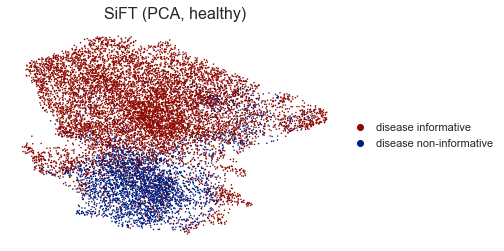

In [8]:
adata_platelets = adata_[adata_.obs["full_clustering"].isin(["Platelets"])].copy()
adata_platelets.uns["informative_cluster_colors"] = ['#8c0800', '#001c7f']
adata_platelets.layers["X_noneg"] = adata_platelets.X - adata_platelets.X.min()
layer = "X_noneg"     
adata_platelets.uns["log1p"] = {'base': None}
sc.tl.rank_genes_groups(
    adata_platelets , 
    groupby="informative_cluster",
    method="wilcoxon",
    layer=layer,
    use_raw=False,
    key_added="cell_informative_rank_genes_groups"
    )
    
process_adata(
    adata_platelets,
    use_rep="X_pca",
    scale=False,
    n_pcs=30,
    n_neighbors=10,
    )       

for color in ["informative_cluster"]:
    sc.pl.umap(
        adata_platelets, 
        color=color,
        frameon=False, 
        show=False
    )
              
    plt.title('SiFT (PCA, healthy)', fontsize=16)
    # plt.savefig(FIG_DIR + f"Platelets_SiFT (PCA, healthy)_{color}_umap.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

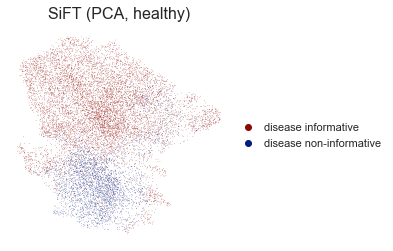

In [9]:
size=4
for color in ["informative_cluster"]:
    fig, axs = plt.subplots(figsize=(size, size))
    sc.pl.umap(
        adata_platelets, 
        color=color,
        frameon=False, 
        size=120000/(adata_.n_obs/5),
        show=False,
        ax=axs
    )
              
    plt.title('SiFT (PCA, healthy)', fontsize=16)
    # plt.savefig(FIG_DIR + f"Platelets_SiFT (PCA, healthy)_{color}_umap.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

In [11]:
ind_genes = adata_platelets.uns["cell_informative_rank_genes_groups"]["names"]["disease informative"]
ind_genes[:50]

array(['FTH1', 'IFI27', 'IFITM3', 'TIMP1', 'MYL9', 'GP9', 'CMTM5', 'BEX3',
       'CTSA', 'FTL', 'MPIG6B', 'PPBP', 'TMEM40', 'HLA-A', 'TPM4', 'ACTB',
       'SPARC', 'ESAM', 'PF4', 'TREML1', 'CLEC1B', 'AC025171.3', 'TKTL1',
       'RAB11A', 'GRAP2', 'MPP1', 'IGKV2-24', 'CKAP4', 'ITM2C',
       'IGKV3-20', 'ILK', 'SNCA', 'TRBV28', 'CD79B', 'TRBV9', 'PTGS1',
       'XIST', 'THAP2', 'SKIL', 'ALG5', 'GMPPA', 'GADD45G', 'EIF2AK1',
       'ID1', 'PCNA', 'KIF22', 'AC016405.3', 'AC087623.2', 'IDH3A',
       'LMO4'], dtype=object)

### [_clusterProfiler_](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html)

use the `R` _clusterProfiler_ package to find GO enrichment terms:
```{r}
genes = ind_genes[:50]

ego <- enrichGO(gene = genes, 
                OrgDb = "org.Hs.eg.db", 
                ont="BP", 
                keyType="SYMBOL",
                readable=FALSE)
ego2 <- simplify(ego)
pl = dotplot(ego2, showCategory=12,)
write.csv(pl$data, "./output/simplifiedgo_sift_platelets_informative.csv)
```

In [14]:
df_cp = pd.read_csv(DATA_DIR + "output/simplifiedgo_sift_platelets_informative.csv")
df_cp = df_cp.sort_values(by=['GeneRatio'], ascending=False)
df_cp["GO term"] = df_cp["Description"].copy()
GO_terms = []
for str_ in df_cp["GO term"]:
    list_ = re.findall(r"[\w']+", str_)
    if len(str_) > 25:
        idx_ = int(len(list_)/2-1)
        list_[idx_] = list_[idx_] + "\n" + list_[idx_+1]
        list_.pop(idx_+1)
        str_ = " ".join(list_)
    GO_terms.append(str_)

df_cp.iloc[:, -1] = GO_terms

In [15]:
df_cp[ "$-log_{10}(p_{adj})$"] = np.round(-1*np.log10(df_cp["p.adjust"]), 2)
df_cp["Gene fraction"] = df_cp["GeneRatio"]

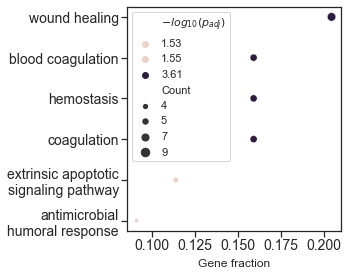

In [17]:
size = 4
fig, axs = plt.subplots(figsize=(size+1, size))
sns.set_theme(style="white")
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

sns.scatterplot(
    data=df_cp,
    x="Gene fraction", 
    y="GO term", 
    size="Count", 
    hue="$-log_{10}(p_{adj})$",
    ax=axs)

plt.legend(frameon=True)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
        
plt.tight_layout()
# plt.savefig(FIG_DIR + f"go_dots_sift_platelets_informative.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Platelet marker genes

In [18]:
platelet_genes = [ "GP9", "MPIG6B","PF4", "CLEC1B", "PPBP", "STXBP2",]

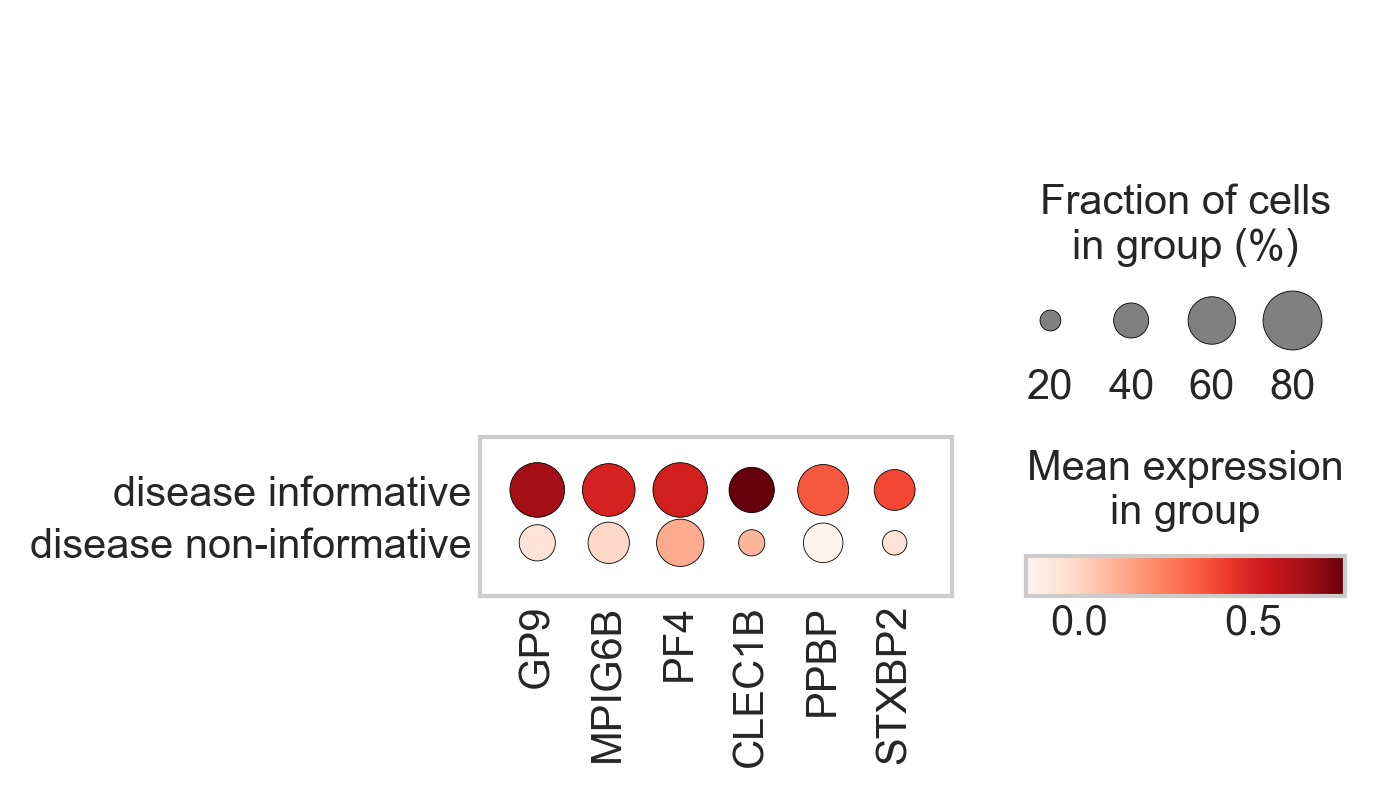

In [23]:
sc.pl.dotplot(
    adata=adata_platelets, 
    var_names=platelet_genes, 
    groupby="informative_cluster",
    show=False
)

# plt.tight_layout()
# plt.savefig(FIG_DIR + f"dotplot_platelets_markers.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Save res

In [ ]:
adata_platelets.write(DATA_DIR + 'covid19.sift.knn.platelets.h5ad')